In [1]:
import ee
import geemap
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib

In [2]:
manaus_shp = '/Users/morgansteckler/Desktop/tile_shapefiles/venus_fgmanaus_footprint/venus_fgmanaus_footprint.shp'
#manaus_shp = '/home/6ru/tile_shapefiles/manaus/venus_fgmanaus_footprint.shp'
manaus = geemap.shp_to_ee(manaus_shp)
info = manaus.geometry()
manaus = ee.Geometry(info)

In [3]:
atto_shp = '/Users/morgansteckler/Desktop/tile_shapefiles/venus_atto_footprint/venus_atto_footprint.shp'
#atto_shp = '/home/6ru/tile_shapefiles/atto/venus_atto_footprint.shp'
atto = geemap.shp_to_ee(atto_shp)
info = atto.geometry()
atto = ee.Geometry(info)

In [4]:
corumba_shp = '/Users/morgansteckler/Desktop/tile_shapefiles/venus_corumba_footprint/venus_corumba_footprint.shp'
#corumba_shp = '/home/6ru/tile_shapefiles/corumba/venus_corumba_footprint.shp'
corumba = geemap.shp_to_ee(corumba_shp)
info = corumba.geometry()
corumba = ee.Geometry(info)

In [5]:
mato_shp = '/Users/morgansteckler/Desktop/tile_shapefiles/venus_mato_footprint/venus_mato_footprint.shp'
#mato_shp = '/home/6ru/tile_shapefiles/mato/venus_mato_footprint.shp'
mato = geemap.shp_to_ee(mato_shp)
info = mato.geometry()
mato = ee.Geometry(info)

In [6]:
saop_shp = '/Users/morgansteckler/Desktop/tile_shapefiles/venus_saop_footprint/venus_saop_footprint.shp'
#saop_shp = '/home/6ru/tile_shapefiles/saop/venus_saop_footprint.shp'
saop = geemap.shp_to_ee(saop_shp)
info = saop.geometry()
saop = ee.Geometry(info)

In [150]:
#IMPORTANT
#Select geom of interest
fc = saop

In [151]:
#Map = geemap.Map()
#Map.centerObject(fc, 10)
#Map

In [152]:
#s2 = (ee.ImageCollection('COPERNICUS/S2')
#      .filterBounds(fc)
#      .select(['B4', 'B3', 'B2'])
#      .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 20)
#      .filterDate(ee.Date('2016-01-01'), ee.Date('2019-12-31')))

In [153]:
#composite = s2.median()
#composite = composite.clip(fc)

In [154]:
#task = ee.batch.Export.image.toDrive(image=composite, description="corumba_rgb_again", folder="test", scale=40, region=fc)
#task.start()

In [155]:
#print(task.status())

In [180]:
#Calculate NDRE and set palette
def addNDRE(image):
    ndre = image.normalizedDifference(['B8', 'B5']).rename('NDRE')
    return image.addBands(ndre)

#Set NDRE parameters for visualization
ndre_params = ({'min': 0.0,'max': 1.0, 'palette' : 
               ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
               '74A901', '66A000', '529400', '3E8601', '207401', '056201',
               '004C00', '023B01', '012E01', '011D01', '011301']})

#Create cloud mask
cloudBitMask = ee.Number(2).pow(10).int() #bit 10 is clouds
cirrusBitMask = ee.Number(2).pow(11).int() #bit 11 is cirrus clouds
def maskS2clouds(image):
    qa = image.select('QA60')
    # Both flags should be set to zero, indicating clear conditions.
    mask = (qa.bitwiseAnd(cloudBitMask).eq(0).And(
             qa.bitwiseAnd(cirrusBitMask).eq(0)))
    return image.updateMask(mask)

In [181]:
#Load sentinel-2 data
s2 = (ee.ImageCollection('COPERNICUS/S2')#Select S2 1-C level data
      .select(['B5', 'B8', 'QA60']) #Select necessary bands to reduce memory usage
      .filterBounds(fc) #Narrow data spatially
      .filterDate(ee.Date('2016-01-01'), ee.Date('2019-12-31')) #Select years of interest
      .sort('CLOUDY_PIXEL_PERCENTAGE', False) #Put smallest %cloud image on top of stack
      .map(addNDRE)) #calculate NDRE and add as band

In [182]:
#Create collection with cloud mask
col = s2.map(maskS2clouds)

In [183]:
#15-day step
years = ee.List.sequence(2016, 2019)
step = ee.List.sequence(1, 365, 15)

def byYear(y):
    y = ee.Number(y)
    def byStep(d):
        d = ee.Number(d)
        return (col
                .filter(ee.Filter.calendarRange(y, y.add(1), 'year')) #yearly step
                .filter(ee.Filter.calendarRange(d, d.add(15), 'day_of_year')) #15-day step
                .qualityMosaic('NDRE') #Max greenness
                .set('step', [d, y])) #Add properties
    return step.map(byStep)

col = ee.ImageCollection.fromImages(years.map(byYear).flatten())
col = col.map(lambda image: image.clip(fc)).select('NDRE')

In [184]:
#Makes sure there are 100 (25 15-day steps * 4 years = 100 composites)
count = col.size().getInfo()
print(count)

100


In [169]:
#Check step property
properties = col.aggregate_array('step').getInfo()
print(properties)

[[1, 2016], [16, 2016], [31, 2016], [46, 2016], [61, 2016], [76, 2016], [91, 2016], [106, 2016], [121, 2016], [151, 2016], [166, 2016], [181, 2016], [196, 2016], [211, 2016], [226, 2016], [241, 2016], [256, 2016], [271, 2016], [286, 2016], [301, 2016], [316, 2016], [331, 2016], [346, 2016], [1, 2017], [16, 2017], [31, 2017], [46, 2017], [61, 2017], [76, 2017], [91, 2017], [106, 2017], [121, 2017], [136, 2017], [151, 2017], [166, 2017], [181, 2017], [196, 2017], [211, 2017], [226, 2017], [241, 2017], [256, 2017], [271, 2017], [286, 2017], [301, 2017], [316, 2017], [331, 2017], [346, 2017], [361, 2017], [1, 2018], [16, 2018], [31, 2018], [46, 2018], [61, 2018], [76, 2018], [91, 2018], [106, 2018], [121, 2018], [136, 2018], [151, 2018], [166, 2018], [181, 2018], [196, 2018], [211, 2018], [226, 2018], [241, 2018], [256, 2018], [271, 2018], [286, 2018], [301, 2018], [316, 2018], [331, 2018], [346, 2018], [361, 2018], [1, 2019], [16, 2019], [31, 2019], [46, 2019], [61, 2019], [76, 2019], [91

In [104]:
#Atto removal: 5, 24
col = (col.filter(ee.Filter.neq('step', [76, 2016])) #5
       .filter(ee.Filter.neq('step', [361, 2016]))) #24

In [185]:
#Saop removal: 9, 24, 99
col = (col.filter(ee.Filter.neq('step', [361, 2019])) #99
       .filter(ee.Filter.neq('step', [361, 2016])) #24
       .filter(ee.Filter.neq('step', [136, 2016]))) #9

In [163]:
#Check step property
#properties = col.aggregate_array('step').getInfo()
#print(properties)

In [186]:
#See how many images are left
count = col.size().getInfo()
print(count)

97


In [165]:
###Stop here for exporting images####

In [187]:
geom = fc

# Mean
def region_mean_Image(img):
    # mean over all pixels in the region for the image
    return img.set('mean', img.reduceRegion(ee.Reducer.mean(), geometry=geom, scale=20)) 

def region_mean_ImageCollection(ic):
    # mean over all pixels in the region, for each image in the ImageCollection
    stats = ic.map(region_mean_Image)
    stats_list = stats.aggregate_array('mean')
    return np.array(stats_list.getInfo())

# Median
def region_median_Image(img):
    # mean over all pixels in the region for the image
    return img.set('median', img.reduceRegion(ee.Reducer.median(), geometry=geom, scale=20)) 

def region_median_ImageCollection(ic):
    # mean over all pixels in the region, for each image in the ImageCollection
    stats = ic.map(region_median_Image)
    stats_list = stats.aggregate_array('median')
    return np.array(stats_list.getInfo())

# Stddev
def region_stddev_Image(img):
    # stddev over all pixels in the region for the image
    return img.set('stddev', img.reduceRegion(ee.Reducer.stdDev(), geometry=geom, scale=20)) 

def region_stddev_ImageCollection(ic):
    # stddev over all pixels in the region, for each image in the ImageCollection
    stats = ic.map(region_stddev_Image)
    stats_list = stats.aggregate_array('stddev')
    return np.array(stats_list.getInfo())

# Percentiles
def region_percentiles_Image(img):
    # 5,10,25,75,90,95 percentiles over all pixels in the region for the image
    return img.set('percentiles', img.reduceRegion(ee.Reducer.percentile([5,10,25,75,90,95]), geometry=geom, scale=20)) #) mean, median, stdDev, percentiles

def region_percentiles_ImageCollection(ic):
    # percentiles over all pixels in the region, for each image in the ImageCollection
    stats = ic.map(region_percentiles_Image)
    stats_list = stats.aggregate_array('percentiles')
    return np.array(stats_list.getInfo())

In [188]:
#Create list of dictionaries as [{'NDRE': value} ...]
mean_list = region_mean_ImageCollection(col)
median_list = region_median_ImageCollection(col)
stddev_list = region_stddev_ImageCollection(col)
percentile_list = region_percentiles_ImageCollection(col)

In [189]:
#Show if there are any blank {} dictionaries
print(mean_list)

[{'NDRE': 0.3934704827161161} {'NDRE': 0.4685730699864421}
 {'NDRE': 0.46830561125398956} {'NDRE': 0.4085965795561707}
 {'NDRE': 0.4439086293393644} {'NDRE': 0.47769574077055377}
 {'NDRE': 0.3641875770117957} {'NDRE': 0.46210716972645816}
 {'NDRE': 0.46482231477112756} {'NDRE': 0.45355048787755226}
 {'NDRE': 0.45384374006901584} {'NDRE': 0.4412496160171165}
 {'NDRE': 0.3859627672562532} {'NDRE': 0.2662326718600179}
 {'NDRE': 0.3725713531626828} {'NDRE': 0.38937608000955315}
 {'NDRE': 0.36357602233237957} {'NDRE': 0.3080041529944357} {'NDRE': None}
 {'NDRE': 0.4036133375108997} {'NDRE': 0.4310844416769545}
 {'NDRE': 0.4279713426112062} {'NDRE': 0.4010405657693768}
 {'NDRE': 0.4492716701426172} {'NDRE': 0.2043492809688213}
 {'NDRE': 0.5002329516308227} {'NDRE': 0.4799126239009946}
 {'NDRE': 0.5125470094261447} {'NDRE': 0.4367453015469922}
 {'NDRE': 0.4944595004457264} {'NDRE': 0.48121716883138527}
 {'NDRE': 0.501663930005153} {'NDRE': 0.43323605695961487}
 {'NDRE': 0.4593072763712081} {'

In [190]:
#Replace empty dicts with {'NDRE': None}
#Atto: 5, 24
#Saop: 9, 24, 99
dic = {'NDRE': None}
p_dic = {'NDRE_p10': None, 'NDRE_p25': None, 'NDRE_p5': None, 'NDRE_p75': None, 'NDRE_p90': None, 'NDRE_p95': None}

In [109]:
#Atto
#Atto: 5, 24 from list of 100
mean_list = np.insert(mean_list, 4, dic)
mean_list = np.insert(mean_list, 23, dic)

median_list = np.insert(median_list, 4, dic) 
median_list = np.insert(median_list, 23, dic)

stddev_list = np.insert(stddev_list, 4, dic)
stddev_list = np.insert(stddev_list, 23, dic)

percentile_list = np.insert(percentile_list, 4, p_dic)
percentile_list = np.insert(percentile_list, 23, p_dic)

In [191]:
#Saop
#Saop: 9, 24, 99 from list of 100
mean_list = np.insert(mean_list, 8, dic) 
mean_list = np.insert(mean_list, 23, dic)
mean_list = np.insert(mean_list, 98, dic)

median_list = np.insert(median_list, 8, dic) 
median_list = np.insert(median_list, 23, dic)
median_list = np.insert(median_list, 98, dic)

stddev_list = np.insert(stddev_list, 8, dic)
stddev_list = np.insert(stddev_list, 23, dic)
stddev_list = np.insert(stddev_list, 98, dic)

percentile_list = np.insert(percentile_list, 8, p_dic) 
percentile_list = np.insert(percentile_list, 23, p_dic) 
percentile_list = np.insert(percentile_list, 98, p_dic) 

In [192]:
print(len(mean_list))

100


In [193]:
#Take only the ndre mean, med, stddev dict values and append to new list
def newList(alist):
    list_name = []
    for value in alist:
        list_name.append(value['NDRE'])
    return list_name

#Append ndre percentile dict values to new lists
def p_list(alist):
    p10, p25, p5, p75, p90, p95 = [], [], [], [], [], []
    for value in alist:
        p5.append(value['NDRE_p5'])
        p10.append(value['NDRE_p10'])
        p25.append(value['NDRE_p25'])
        p75.append(value['NDRE_p75'])
        p90.append(value['NDRE_p90'])
        p95.append(value['NDRE_p95'])
    return p5, p10, p25, p75, p90, p95

In [194]:
#Make lists for each set of values
mean_ndre = newList(mean_list)
median_ndre = newList(median_list)
stddev_ndre = newList(stddev_list)
percentile_ndre = p_list(percentile_list)

In [195]:
#Change None values to np.nan so graphs will skip those Nulls
mean_ndre = [np.nan if v is None else v for v in mean_ndre]
median_ndre = [np.nan if v is None else v for v in median_ndre]
stddev_ndre = [np.nan if v is None else v for v in stddev_ndre]
percentile_ndre = [np.nan if v is None else v for v in percentile_ndre]

In [196]:
#Make lists with +/- SD
plus_error = [x + y for x,y in zip(mean_ndre, stddev_ndre)]
minus_error = [x - y for x,y in zip(mean_ndre, stddev_ndre)]

In [197]:
#Create 15-step list for four years
period = list(range(0,100))
period = np.array(period)

In [198]:
import matplotlib
matplotlib.rcParams['font.serif'] = "Times New Roman"
matplotlib.rcParams['font.family'] = "serif"

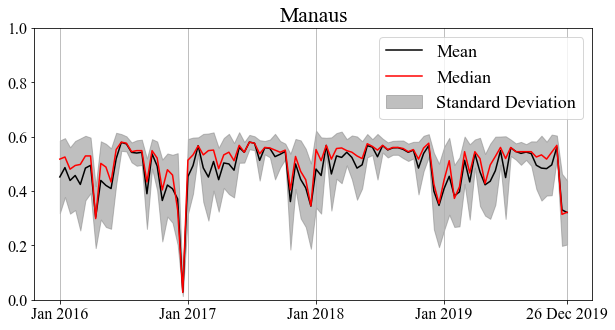

In [91]:
#Manaus
#Mean and SD
%matplotlib inline

x = period
y = mean_ndre
m = median_ndre

plt.figure(figsize=((10,5)))

plt.plot(x,y, color = "black", label = "Mean")
plt.plot(x,m, color = "red", label = "Median")
plt.fill_between(x, plus_error, minus_error, color = "grey", alpha = .5, label = "Standard Deviation")

plt.rc('font', size=18)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

plt.rcParams.update({'font.size': 18})
plt.ylim(bottom = 0, top = 1)
plt.grid(b = True, which = 'major', axis = 'x')
plt.title('Manaus')
plt.legend(loc = "upper right")
plt.xticks(ticks = [0, 25, 50, 75, 99], labels = ['Jan 2016', 'Jan 2017', 'Jan 2018', 'Jan 2019', '26 Dec 2019'])

plt.savefig('/Users/morgansteckler/Desktop/General_Phenology/manaus.png', bbox_inches='tight')

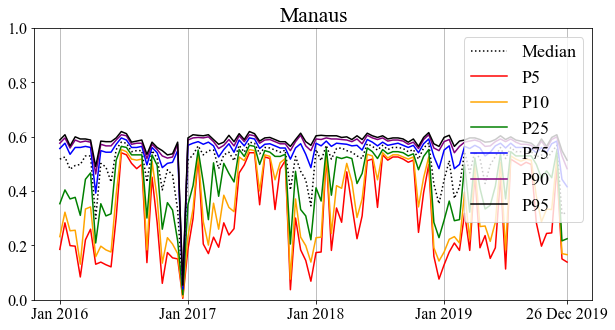

In [92]:
#Manaus
#Median and Percentiles
%matplotlib inline
x = period

plt.figure(figsize=((10,5)))

plt.plot(x,m, color = "black", linestyle = ":", label = "Median")
plt.plot(x,percentile_ndre[0], color = "red", label = "P5")
plt.plot(x,percentile_ndre[1], color = "orange", label = "P10")
plt.plot(x,percentile_ndre[2], color = "green", label = "P25")
plt.plot(x,percentile_ndre[3], color = "blue", label = "P75")
plt.plot(x,percentile_ndre[4], color = "purple", label = "P90")
plt.plot(x,percentile_ndre[5], color = "black", label = "P95")

plt.rc('font', size=18)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

plt.ylim(bottom = 0, top = 1)
plt.grid(b = True, which = 'major', axis = 'x')
plt.title('Manaus')
plt.legend(loc = "upper right")
plt.xticks(ticks = [0, 25, 50, 75, 99], labels = ['Jan 2016', 'Jan 2017', 'Jan 2018', 'Jan 2019', '26 Dec 2019'])

plt.savefig('/Users/morgansteckler/Desktop/General_Phenology/manaus_pc.png', bbox_inches='tight')

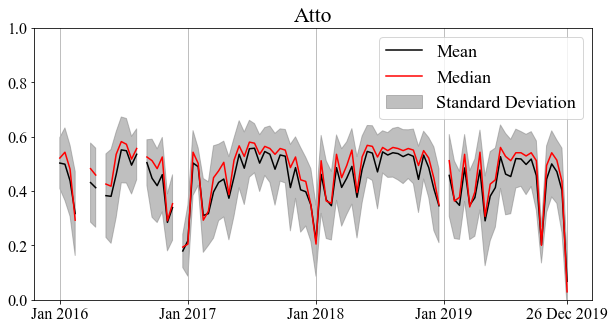

In [119]:
#Atto
#Mean and SD
%matplotlib inline

x = period
y = mean_ndre
m = median_ndre

plt.figure(figsize=((10,5)))

plt.plot(x,y, color = "black", label = "Mean")
plt.plot(x,m, color = "red", label = "Median")
plt.fill_between(x, plus_error, minus_error, color = "grey", alpha = .5, label = "Standard Deviation")

plt.rc('font', size=18)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

plt.ylim(bottom = 0, top = 1)
plt.grid(b = True, which = 'major', axis = 'x')
plt.title('Atto')
plt.legend(loc = "upper right")
plt.xticks(ticks = [0, 25, 50, 75, 99], labels = ['Jan 2016', 'Jan 2017', 'Jan 2018', 'Jan 2019', '26 Dec 2019'])

plt.savefig('/Users/morgansteckler/Desktop/General_Phenology/atto.png', bbox_inches='tight')

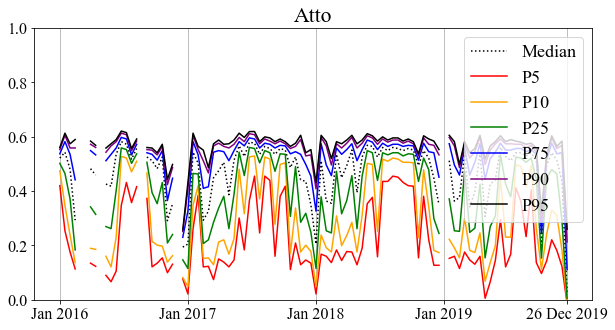

In [120]:
#Atto
#Median and Percentiles
%matplotlib inline
x = period

plt.figure(figsize=((10,5)))

plt.plot(x,m, color = "black", linestyle = ":", label = "Median")
plt.plot(x,percentile_ndre[0], color = "red", label = "P5")
plt.plot(x,percentile_ndre[1], color = "orange", label = "P10")
plt.plot(x,percentile_ndre[2], color = "green", label = "P25")
plt.plot(x,percentile_ndre[3], color = "blue", label = "P75")
plt.plot(x,percentile_ndre[4], color = "purple", label = "P90")
plt.plot(x,percentile_ndre[5], color = "black", label = "P95")

plt.rc('font', size=18)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

plt.ylim(bottom = 0, top = 1)
plt.grid(b = True, which = 'major', axis = 'x')
plt.title('Atto')
plt.legend(loc = "upper right")
plt.xticks(ticks = [0, 25, 50, 75, 99], labels = ['Jan 2016', 'Jan 2017', 'Jan 2018', 'Jan 2019', '26 Dec 2019'])

plt.savefig('/Users/morgansteckler/Desktop/General_Phenology/atto_pc.png', bbox_inches='tight')

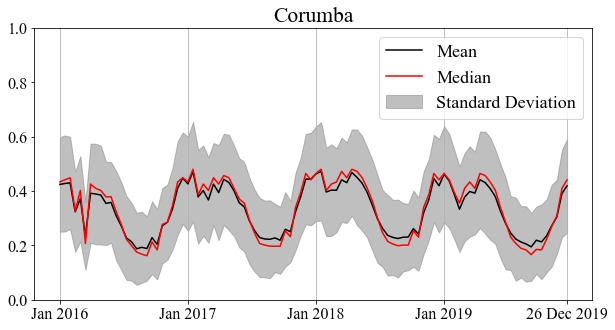

In [136]:
#Corumba
#Mean and SD
%matplotlib inline

x = period
y = mean_ndre
m = median_ndre

plt.figure(figsize=((10,5)))

plt.plot(x,y, color = "black", label = "Mean")
plt.plot(x,m, color = "red", label = "Median")
plt.fill_between(x, plus_error, minus_error, color = "grey", alpha = .5, label = "Standard Deviation")

plt.rc('font', size=18)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

plt.ylim(bottom = 0, top = 1)
plt.grid(b = True, which = 'major', axis = 'x')
plt.title('Corumba')
plt.legend(loc = "upper right")
plt.xticks(ticks = [0, 25, 50, 75, 99], labels = ['Jan 2016', 'Jan 2017', 'Jan 2018', 'Jan 2019', '26 Dec 2019'])

plt.savefig('/Users/morgansteckler/Desktop/General_Phenology/corumba.png', bbox_inches='tight')

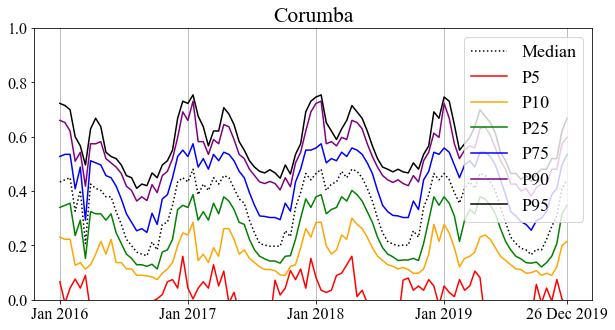

In [137]:
#Corumba
#Median and Percentiles
%matplotlib inline
x = period

plt.figure(figsize=((10,5)))

plt.plot(x,m, color = "black", linestyle = ":", label = "Median")
plt.plot(x,percentile_ndre[0], color = "red", label = "P5")
plt.plot(x,percentile_ndre[1], color = "orange", label = "P10")
plt.plot(x,percentile_ndre[2], color = "green", label = "P25")
plt.plot(x,percentile_ndre[3], color = "blue", label = "P75")
plt.plot(x,percentile_ndre[4], color = "purple", label = "P90")
plt.plot(x,percentile_ndre[5], color = "black", label = "P95")

plt.rc('font', size=18)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

plt.ylim(bottom = 0, top = 1)
plt.grid(b = True, which = 'major', axis = 'x')
plt.title('Corumba')
plt.legend(loc = "upper right")
plt.xticks(ticks = [0, 25, 50, 75, 99], labels = ['Jan 2016', 'Jan 2017', 'Jan 2018', 'Jan 2019', '26 Dec 2019'])

plt.savefig('/Users/morgansteckler/Desktop/General_Phenology/corumba_pc.png', bbox_inches='tight')

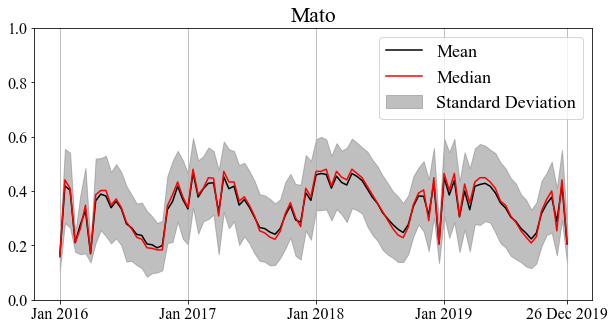

In [73]:
#Mato
#Mean and SD
%matplotlib inline

x = period
y = mean_ndre
m = median_ndre

plt.figure(figsize=((10,5)))

plt.plot(x,y, color = "black", label = "Mean")
plt.plot(x,m, color = "red", label = "Median")
plt.fill_between(x, plus_error, minus_error, color = "grey", alpha = .5, label = "Standard Deviation")

plt.rc('font', size=18)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

plt.ylim(bottom = 0, top = 1)
plt.grid(b = True, which = 'major', axis = 'x')
plt.title('Mato')
plt.legend(loc = "upper right")
plt.xticks(ticks = [0, 25, 50, 75, 99], labels = ['Jan 2016', 'Jan 2017', 'Jan 2018', 'Jan 2019', '26 Dec 2019'])

plt.savefig('/Users/morgansteckler/Desktop/General_Phenology/mato.png', bbox_inches='tight')

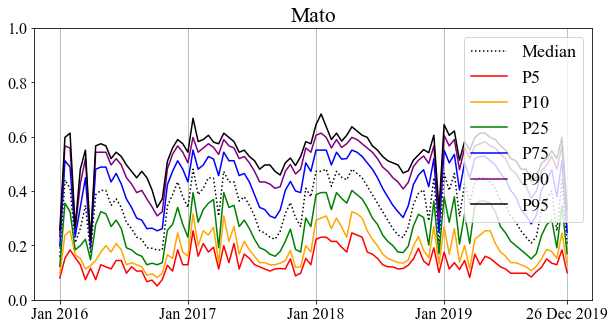

In [75]:
#Mato
#Median and Percentiles
%matplotlib inline
x = period

plt.figure(figsize=((10,5)))

plt.plot(x,m, color = "black", linestyle = ":", label = "Median")
plt.plot(x,percentile_ndre[0], color = "red", label = "P5")
plt.plot(x,percentile_ndre[1], color = "orange", label = "P10")
plt.plot(x,percentile_ndre[2], color = "green", label = "P25")
plt.plot(x,percentile_ndre[3], color = "blue", label = "P75")
plt.plot(x,percentile_ndre[4], color = "purple", label = "P90")
plt.plot(x,percentile_ndre[5], color = "black", label = "P95")

plt.rc('font', size=18)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

plt.ylim(bottom = 0, top = 1)
plt.grid(b = True, which = 'major', axis = 'x')
plt.title('Mato')
plt.legend(loc = "upper right")
plt.xticks(ticks = [0, 25, 50, 75, 99], labels = ['Jan 2016', 'Jan 2017', 'Jan 2018', 'Jan 2019', '26 Dec 2019'])

plt.savefig('/Users/morgansteckler/Desktop/General_Phenology/mato_pc.png', bbox_inches='tight')

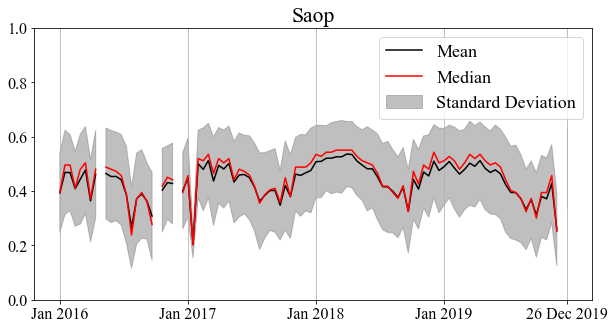

In [201]:
#Saop
#Mean and SD
%matplotlib inline

x = period
y = mean_ndre
m = median_ndre

plt.figure(figsize=((10,5)))

plt.plot(x,y, color = "black", label = "Mean")
plt.plot(x,m, color = "red", label = "Median")
plt.fill_between(x, plus_error, minus_error, color = "grey", alpha = .5, label = "Standard Deviation")

plt.rc('font', size=18)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

plt.ylim(bottom = 0, top = 1)
plt.grid(b = True, which = 'major', axis = 'x')
plt.title('Saop')
plt.legend(loc = "upper right")
plt.xticks(ticks = [0, 25, 50, 75, 99], labels = ['Jan 2016', 'Jan 2017', 'Jan 2018', 'Jan 2019', '26 Dec 2019'])

plt.savefig('/Users/morgansteckler/Desktop/General_Phenology/saop.png', bbox_inches='tight')

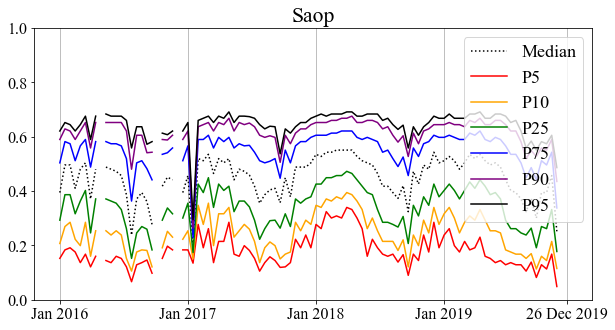

In [202]:
#Saop
#Median and Percentiles
%matplotlib inline
x = period

plt.figure(figsize=((10,5)))

plt.plot(x,m, color = "black", linestyle = ":", label = "Median")
plt.plot(x,percentile_ndre[0], color = "red", label = "P5")
plt.plot(x,percentile_ndre[1], color = "orange", label = "P10")
plt.plot(x,percentile_ndre[2], color = "green", label = "P25")
plt.plot(x,percentile_ndre[3], color = "blue", label = "P75")
plt.plot(x,percentile_ndre[4], color = "purple", label = "P90")
plt.plot(x,percentile_ndre[5], color = "black", label = "P95")

plt.rc('font', size=18)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

plt.ylim(bottom = 0, top = 1)
plt.grid(b = True, which = 'major', axis = 'x')
plt.title('Saop')
plt.legend(loc = "upper right")
plt.xticks(ticks = [0, 25, 50, 75, 99], labels = ['Jan 2016', 'Jan 2017', 'Jan 2018', 'Jan 2019', '26 Dec 2019'])

plt.savefig('/Users/morgansteckler/Desktop/General_Phenology/saop_pc.png', bbox_inches='tight')

In [45]:
#Export images from a collection
#out_dir = '/home/6ru/tiles/saop/'
#geemap.ee_export_image_collection(col, out_dir, region = fc, scale = 20, file_per_band=False)